# Prueba técnica 
# Objetivo: Predecir PAY_AMT4 (regresión) y default.payment.next.month (clasificación)

"""
Notebook documentado para análisis de impago de clientes de tarjetas de crédito.
Incluye limpieza, exploración, creación de variables, modelado supervisado y evaluación.

Autores: Ilse Alejandra Aguilar Segoviano
Fecha: 28 de Junio del 2025
"""


## Importación de librerias 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBClassifier, XGBRegressor

### 1. Carga de datos

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)

In [14]:
df

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


### Limpieza de nombres de columna para evitar errores posteriores

In [3]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

## 2. Exploración inicial del dataset 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   id                          30000 non-null  int64
 1   limit_bal                   30000 non-null  int64
 2   sex                         30000 non-null  int64
 3   education                   30000 non-null  int64
 4   marriage                    30000 non-null  int64
 5   age                         30000 non-null  int64
 6   pay_0                       30000 non-null  int64
 7   pay_2                       30000 non-null  int64
 8   pay_3                       30000 non-null  int64
 9   pay_4                       30000 non-null  int64
 10  pay_5                       30000 non-null  int64
 11  pay_6                       30000 non-null  int64
 12  bill_amt1                   30000 non-null  int64
 13  bill_amt2                   30000 non-null  int64
 14  bill_a

In [8]:
df.describe()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


### Historial de pagos

In [16]:
df[['pay_0', 'pay_2','pay_3', 'pay_4','pay_5','pay_6']].describe()

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


### Pagos previos y cantidad en el ectracto de la factura

In [18]:
df[['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']].describe()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [21]:
df[['pay_amt1', 'pay_amt2','pay_amt3', 'pay_amt4','pay_amt5','pay_amt6']].describe()

,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [11]:
df[['limit_bal', 'sex', 'education', 'marriage', 'age']].describe()

,limit_bal,sex,education,marriage,age
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500
std,129747.661567,0.489129,0.790349,0.521970,9.217904
min,10000.000000,1.000000,0.000000,0.000000,21.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000


In [9]:
df.isnull().sum()

id                            0
limit_bal                     0
sex                           0
education                     0
marriage                      0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt1                     0
bill_amt2                     0
bill_amt3                     0
bill_amt4                     0
bill_amt5                     0
bill_amt6                     0
pay_amt1                      0
pay_amt2                      0
pay_amt3                      0
pay_amt4                      0
pay_amt5                      0
pay_amt6                      0
default_payment_next_month    0
dtype: int64

In [23]:
df['default_payment_next_month'].value_counts()

default_payment_next_month
0    23364
1     6636
Name: count, dtype: int64

### Insights Principales 

El 78% de nuestros clientes históricamente han pagado a tiempo, pero el 22% no lo ha hecho. Aunque los clientes con impago son menos, son justamente los que más interesa identificar.

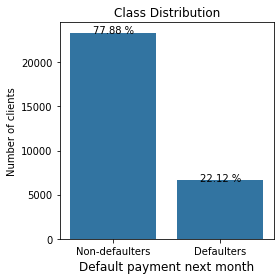

In [28]:
plt.figure(figsize = (4,4))
graph_target = sns.countplot(x="default_payment_next_month", data=df)

i=0
for p in graph_target.patches:
    height = p.get_height()
    
    percentage = round(100 * df["default_payment_next_month"].value_counts()[i] / len(df),2)
    
    str_plot = f'{percentage} %'
    
    graph_target.text(p.get_x()+p.get_width()/2., height - 100, str_plot, ha="center")
    i += 1
    
plt.title('Class Distribution')
plt.xticks([0,1],['Non-defaulters', 'Defaulters'])
plt.xlabel('Default payment next month', fontsize=12)
plt.ylabel('Number of clients')
plt.tight_layout()
plt.show()


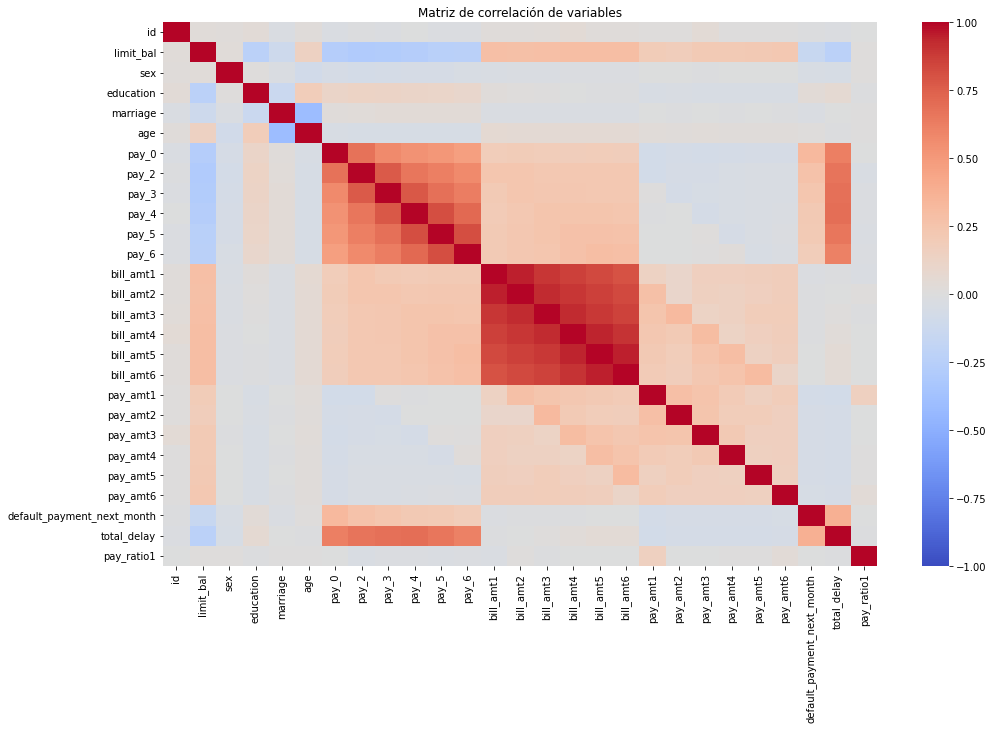

In [68]:
plt.figure(figsize=(16,10))
corr = df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de correlación de variables")
plt.show()

### Análisis basado en su edad y límite de crédito
Analizando la edad y el límite de crédito, encontramos que los clientes con menor edad y menor límite tienen más probabilidades de caer en impago. Esto puede deberse a menor estabilidad financiera o historial crediticio limitado. El modelo puede aprovechar esta información para anticipar riesgos

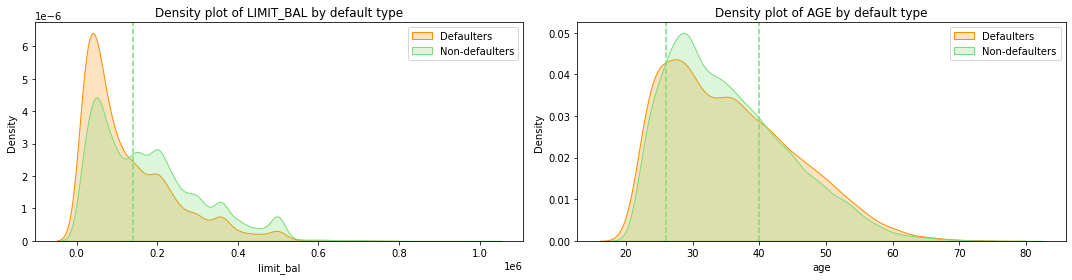

In [32]:
sns.set_palette(palette=['#77DD76','#FF6962'])
fig, axs = plt.subplots(1, 2, figsize=(15,4))

class_0 = df.loc[df['default_payment_next_month'] == 0]['limit_bal']
class_1 = df.loc[df['default_payment_next_month'] == 1]['limit_bal']
axs[0].set_title('Density plot of LIMIT_BAL by default type')
sns.kdeplot(class_1, fill=True, label='Defaulters', color='darkorange', ax=axs[0])
sns.kdeplot(class_0, fill=True, label='Non-defaulters', ax=axs[0])
axs[0].axvline(0.14*1e6, 0, ls='--')
axs[0].legend()

class_0 = df.loc[df['default_payment_next_month'] == 0]['age']
class_1 = df.loc[df['default_payment_next_month'] == 1]['age']
axs[1].set_title('Density plot of AGE by default type')
sns.kdeplot(class_1, fill=True, label='Defaulters', color='darkorange', ax=axs[1])
sns.kdeplot(class_0, fill=True, label='Non-defaulters', ax=axs[1])
axs[1].axvline(26, 0, ls='--')
axs[1].axvline(40, 0, ls='--')
axs[1].legend()

fig.tight_layout()
plt.show()


### Análisis basado en su estado civil, educación y sexo
Analizamos cómo se relacionan características como género, nivel educativo y estado civil con el comportamiento de pago. Vimos que el nivel educativo sí tiene una correlación con el impago: a menor educación, mayor riesgo. El género y el estado civil por sí solos no muestran diferencias claras, pero podrían aportar valor cuando se combinan con otras variables.

/var/folders/_n/cctqc35532j0wjvfc8_vgc540000gn/T/ipykernel_21994/1207675911.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(['Male', 'Female'])
/var/folders/_n/cctqc35532j0wjvfc8_vgc540000gn/T/ipykernel_21994/1207675911.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Graduate School', 'University', 'High School', 'Others'])
/var/folders/_n/cctqc35532j0wjvfc8_vgc540000gn/T/ipykernel_21994/1207675911.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(['Married', 'Single', 'Others'])


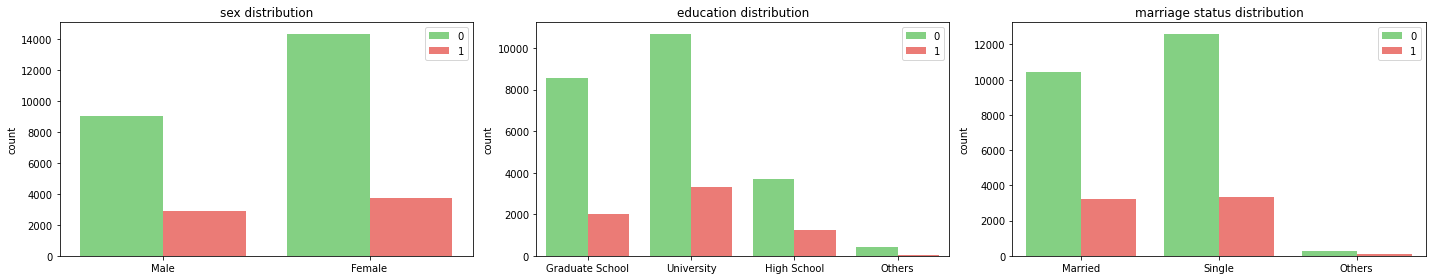

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(20,4))

axs[0].set_title('sex distribution')
sns.countplot(x='sex', hue='default_payment_next_month', data=df, ax=axs[0])
axs[0].set_xticklabels(['Male', 'Female'])
axs[0].set_xlabel('')
axs[0].legend()

axs[1].set_title('education distribution')
sns.countplot(x='education', hue='default_payment_next_month', data=df, ax=axs[1])
axs[1].set_xticklabels(['Graduate School', 'University', 'High School', 'Others'])
axs[1].set_xlabel('')
axs[1].legend()

axs[2].set_title('marriage status distribution')
sns.countplot(x='marriage', hue='default_payment_next_month', data=df, ax=axs[2])
axs[2].set_xticklabels(['Married', 'Single', 'Others'])
axs[2].set_xlabel('')
axs[2].legend()

fig.tight_layout()
plt.show()

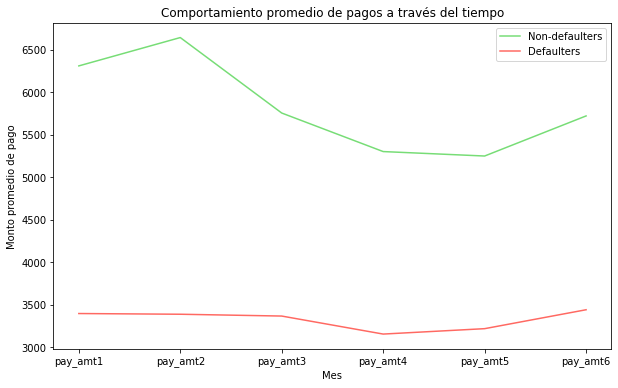

In [66]:
pay_cols = ['pay_amt1','pay_amt2','pay_amt3','pay_amt4','pay_amt5','pay_amt6']
mean_payments = df.groupby('default_payment_next_month')[pay_cols].mean().T

plt.figure(figsize=(10,6))
for status in mean_payments.columns:
    plt.plot(mean_payments.index, mean_payments[status], label='Defaulters' if status else 'Non-defaulters')
plt.title('Comportamiento promedio de pagos a través del tiempo')
plt.xlabel('Mes')
plt.ylabel('Monto promedio de pago')
plt.legend()
plt.show()

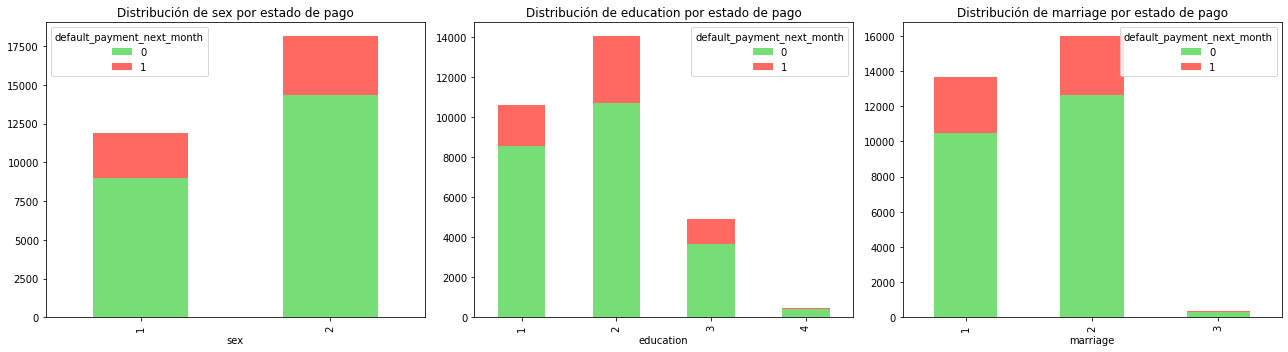

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for i, col in enumerate(['sex', 'education', 'marriage']):
    pd.crosstab(df[col], df['default_payment_next_month']).plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {col} por estado de pago')
plt.tight_layout()
plt.show()

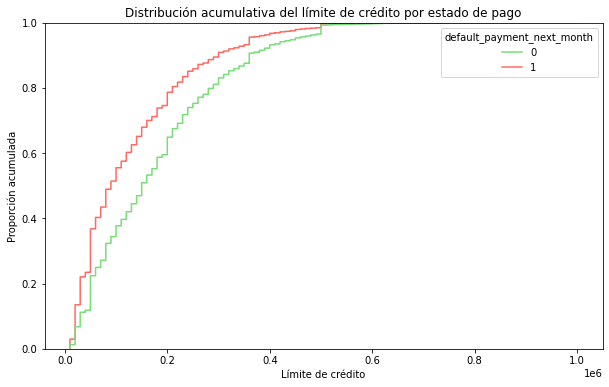

In [69]:
plt.figure(figsize=(10,6))
sns.ecdfplot(data=df, x='limit_bal', hue='default_payment_next_month', stat='proportion')
plt.title('Distribución acumulativa del límite de crédito por estado de pago')
plt.xlabel('Límite de crédito')
plt.ylabel('Proporción acumulada')
plt.show()

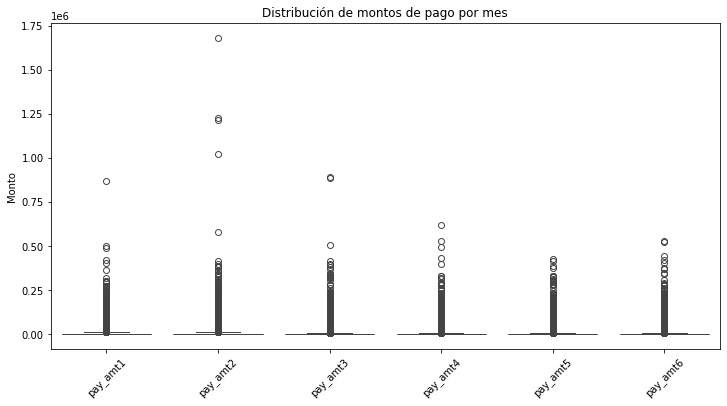

In [70]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['pay_amt1','pay_amt2','pay_amt3','pay_amt4','pay_amt5','pay_amt6']])
plt.title('Distribución de montos de pago por mes')
plt.ylabel('Monto')
plt.xticks(rotation=45)
plt.show()

## 3. Limpieza de datos

In [38]:
print(df['education'].value_counts())

education
2    14030
1    10585
3     4917
4      468
Name: count, dtype: int64


In [39]:
print(df['marriage'].value_counts())

marriage
2    15964
1    13659
3      377
Name: count, dtype: int64


La variable education en el dataset tiene valores como:

1: Posgrado

2: Universidad

3: Preparatoria

4: Otros

5, 6, 0: valores no documentados correctamente o considerados inválidos

0, 5 y 6 no aparecen en la documentación oficial del dataset, y probablemente representan errores de captura o categorías desconocidas.

En vez de eliminarlos (y perder datos), los agrupamos dentro de la categoría "4", que ya está etiquetada como “otros”.



In [40]:
df['education'] = df['education'].replace({0: 4, 5: 4, 6: 4})

In [41]:
df['marriage'] = df['marriage'].replace({0: 3})

## 4. Feature engineering (creación de variables)

### Suma total de retrasos positivos en pagos

In [42]:
delay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

In [43]:
df['total_delay'] = df[delay_cols].apply(lambda row: sum([x if x > 0 else 0 for x in row]), axis=1)

In [44]:
df['pay_ratio1'] = df['pay_amt1'] / (df['bill_amt1'] + 1)

### 5. Separación de datasets para cada objetivo

### Para regresión (pay_amt4) 

In [45]:
drop_cols_reg = ['pay_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt5', 'pay_amt6']

In [46]:
X_reg = df.drop(columns=drop_cols_reg)

In [47]:
y_reg = df['pay_amt4']

In [48]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

### Para clasificación (default) 

In [49]:
X_clf = df.drop(columns=['default_payment_next_month'])

In [50]:
y_clf = df['default_payment_next_month']

In [51]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

### 6. Eliminación de filas con NaNs o Infs

In [52]:
def remove_nan_inf(X, y):
    mask = X.notnull().all(axis=1) & np.isfinite(X).all(axis=1)
    return X[mask], y[mask]

In [53]:
X_train_clf, y_train_clf = remove_nan_inf(X_train_clf, y_train_clf)

In [54]:
X_test_clf, y_test_clf = remove_nan_inf(X_test_clf, y_test_clf)

In [55]:
X_train_reg, y_train_reg = remove_nan_inf(X_train_reg, y_train_reg)

In [56]:
X_test_reg, y_test_reg = remove_nan_inf(X_test_reg, y_test_reg)

### 7. Modelado regresión

In [57]:
reg_model = XGBRegressor(random_state=42)

In [58]:
reg_model.fit(X_train_reg, y_train_reg)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [59]:
y_pred_reg = reg_model.predict(X_test_reg)

In [60]:
print("\nRegresión - PAY_AMT4")
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))
print("R2:", r2_score(y_test_reg, y_pred_reg))


Regresión - PAY_AMT4
MAE: 4410.4130859375
RMSE: 13460.814834177016
R2: -0.10630321502685547


### 8. Modelado clasificación

In [61]:
clf_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf_model.fit(X_train_clf, y_train_clf)
y_pred_clf = clf_model.predict(X_test_clf)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:16:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [62]:
print("\nClasificación - Default")
print(classification_report(y_test_clf, y_pred_clf))
print("AUC:", roc_auc_score(y_test_clf, clf_model.predict_proba(X_test_clf)[:,1]))


Clasificación - Default
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4685
           1       0.63      0.37      0.47      1312

    accuracy                           0.82      5997
   macro avg       0.74      0.65      0.68      5997
weighted avg       0.80      0.82      0.80      5997

AUC: 0.7701574172892208


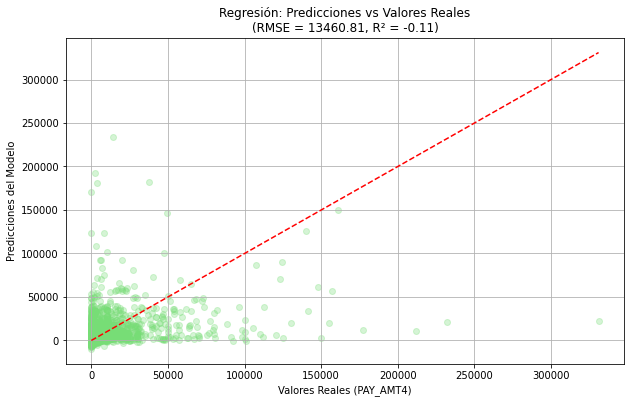

In [73]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.3)
plt.plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], '--r')
plt.xlabel('Valores Reales (PAY_AMT4)')
plt.ylabel('Predicciones del Modelo')
plt.title('Regresión: Predicciones vs Valores Reales\n(RMSE = {:.2f}, R² = {:.2f})'.format(
    np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)),
    r2_score(y_test_reg, y_pred_reg)))
plt.grid(True)
plt.show()

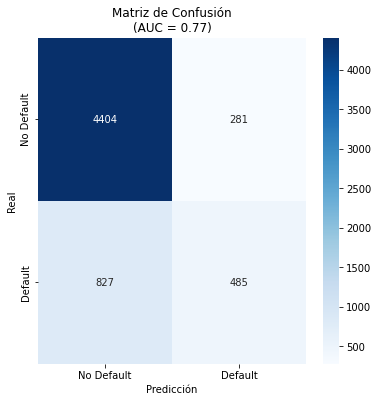

In [74]:
cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión\n(AUC = {:.2f})'.format(
    roc_auc_score(y_test_clf, clf_model.predict_proba(X_test_clf)[:, 1])))
plt.show()

In [77]:
from sklearn.metrics import precision_score, recall_score  # Añade estos imports

metrics = {
    'Modelo': ['Regresión (PAY_AMT4)', 'Clasificación (Default)'],
    'Métrica 1': ['RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))),
                 'Precisión: {:.2f}'.format(precision_score(y_test_clf, y_pred_clf))],
    'Métrica 2': ['R²: {:.2f}'.format(r2_score(y_test_reg, y_pred_reg)),
                 'Recall: {:.2f}'.format(recall_score(y_test_clf, y_pred_clf))],
    'Métrica 3': ['MAE: {:.2f}'.format(mean_absolute_error(y_test_reg, y_pred_reg)),
                 'AUC: {:.2f}'.format(roc_auc_score(y_test_clf, clf_model.predict_proba(X_test_clf)[:, 1]))]
}

pd.DataFrame(metrics).style.hide(axis="index").set_caption("Resumen de Métricas por Modelo")

Modelo,Métrica 1,Métrica 2,Métrica 3
Regresión (PAY_AMT4),RMSE: 13460.81,R²: -0.11,MAE: 4410.41
Clasificación (Default),Precisión: 0.63,Recall: 0.37,AUC: 0.77


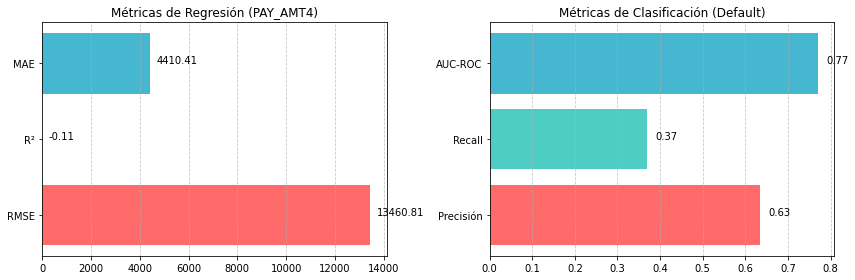

In [79]:
from sklearn.metrics import precision_score, recall_score, mean_squared_error, r2_score, mean_absolute_error, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Calcular todas las métricas primero
# Para regresión
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)

# Para clasificación
precision = precision_score(y_test_clf, y_pred_clf)
recall = recall_score(y_test_clf, y_pred_clf)
auc = roc_auc_score(y_test_clf, clf_model.predict_proba(X_test_clf)[:, 1])

# 2. Crear la visualización
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de regresión
ax[0].barh(['RMSE', 'R²', 'MAE'], [rmse, r2, mae], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax[0].set_title('Métricas de Regresión (PAY_AMT4)')
ax[0].grid(axis='x', linestyle='--', alpha=0.7)

# Añadir valores como texto
for i, v in enumerate([rmse, r2, mae]):
    ax[0].text(v + 0.02 * max([rmse, r2, mae]), i, f'{v:.2f}', color='black')

# Gráfico de clasificación
ax[1].barh(['Precisión', 'Recall', 'AUC-ROC'], [precision, recall, auc], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax[1].set_title('Métricas de Clasificación (Default)')
ax[1].grid(axis='x', linestyle='--', alpha=0.7)

# Añadir valores como texto
for i, v in enumerate([precision, recall, auc]):
    ax[1].text(v + 0.02, i, f'{v:.2f}', color='black')

plt.tight_layout()
plt.show()

### 9. Importancia de variables

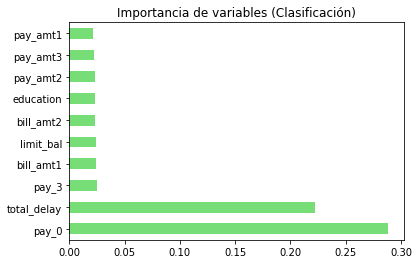

In [63]:
importances = pd.Series(clf_model.feature_importances_, index=X_clf.columns)
importances.nlargest(10).plot(kind='barh')
plt.title('Importancia de variables (Clasificación)')
plt.show()
